<a href="https://colab.research.google.com/github/shubymao/comp551-p3/blob/shuby-dev/Project_3_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 - Convolution Neural Network

## Team Members

Le-Li Mao (260800098)

Victor Livernoche (260926276)

Enan Ashaduzzaman (260805923)

## Initializing Dependency

In [1]:
from __future__ import print_function
import pickle as pkl
import numpy as np
import argparse
from tqdm import tqdm
from sklearn.preprocessing import normalize
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision.transforms.functional as TF
from torchvision.transforms import *
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import string
from google.colab import drive
drive.mount('/content/drive')
# print(torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Mounted at /content/drive
cpu


## Loading Data

In [3]:
mapping = list(string.ascii_lowercase) 
training_data, training_labels, testing_data = None, None, None
with open("/content/drive/My Drive/data/images_l.pkl", 'rb') as f: 
    training_data = pkl.load(f)
    validation_size = training_data.shape[0]//10
    validation_data = training_data[0:validation_size]
    training_data = training_data[validation_size:]
with open("/content/drive/My Drive/data/labels_l.pkl", 'rb') as f: 
    training_labels = pkl.load(f)
    validation_size = training_labels.shape[0]//10
    validation_labels = training_labels[0:validation_size]
    training_labels = training_labels[validation_size:]
with open("/content/drive/My Drive/data/images_test.pkl", 'rb') as f: 
    testing_data = pkl.load(f)

## Preprocessing

### Preprocessing Helper Functions

In [2]:
def convert_labels_to_readables(labels):
  readables = []
  for label in labels:
    l1, l2 = int(label[0]), mapping[label[1].int()]
    readables.append((l1,l2,))
  return readables

In [4]:
# show images
def img_grid(row,col,imgs):
  if imgs is None: return
  for r in range(row):
    fig, axs = plt.subplots(nrows=1, ncols=col, figsize=(7.,10.))
    for i, ax in enumerate(axs.flatten()):
        if(len(imgs) <= r*col+i): 
          return
        plt.sca(ax)
        plt.imshow(imgs[r*col+i])    
    # plt.colorbar()
    plt.show()

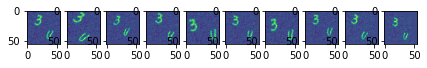

In [17]:
affine_manager = RandomAffine(25, (4/56,4/56), (0.8,1.2), 20)
def generate_affine(image_tensor, num):
    outputs = []
    for _ in range(num):
      outputs.append(affine_manager(image_tensor))
    return outputs

sample_tensor = torch.from_numpy(training_data[0,None]).float()
affined_tensors = map(lambda x: x[0], generate_affine(sample_tensor,9))
img_grid(1,10,[sample_tensor[0],*affined_tensors])

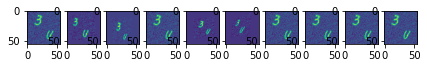

In [23]:
perspective_manager = RandomPerspective(0.6)
def generate_pespective(image_tensor, num):
    outputs = []
    for _ in range(num):
      outputs.append(perspective_manager(image_tensor))
    return outputs

sample_tensor = torch.from_numpy(training_data[0,None]).float()
perspective_tensors = map(lambda x: x[0], generate_pespective(sample_tensor,9))
img_grid(1,10,[sample_tensor[0],*perspective_tensors])

In [24]:
# transform all data to the output format
def process_training_data(data, labels, affine_cnt = 0, perspective_cnt = 0):
  multiplier = (1+affine_cnt+perspective_cnt)
  data_tensor = torch.from_numpy(data[:,None]).float()
  new_data = torch.empty((len(data)*multiplier,1,56,56))
  num_labels = torch.empty(len(data)*multiplier)
  letter_labels = torch.empty(len(data)*multiplier)
  output_index = 0
  for i in tqdm(range(len(data_tensor))):
    # Assign the labels to the new data
    num_labels[i*multiplier:(i+1)*multiplier] = int(np.argmax(labels[i,0:10]))
    letter_labels[i*multiplier:(i+1)*multiplier] = int(np.argmax(labels[i,10:]))
    # Creating the rotation and sharpness images
    mean, std = torch.mean(data_tensor[i]), torch.std(data_tensor[i])
    norm_img = TF.normalize(data_tensor[i], [mean], [std])
    new_data[output_index] = norm_img; output_index+=1
    for r_img in generate_affine(norm_img, affine_cnt):
      new_data[output_index] = r_img; output_index+=1
    for s_img in generate_pespective(norm_img, perspective_cnt):
      new_data[output_index] = s_img; output_index+=1
  
  # Creating the datasets
  multi_label_tensor = torch.stack((num_labels,letter_labels), axis=1).long()
  dataset = TensorDataset(new_data, multi_label_tensor)
  return dataset
  

In [25]:
def process_testing_data(data):
  data_tensor = torch.from_numpy(data[:,None]).float()
  dataset = torch.empty((len(data),1,56,56))
  for i in tqdm(range(len(data_tensor))):
    mean, std = torch.mean(data_tensor[i]), torch.std(data_tensor[i])
    norm_img = TF.normalize(data_tensor[i], [mean], [std])
    dataset[i] = norm_img
  return dataset
testing_dataset = process_testing_data(testing_data)

100%|██████████| 15000/15000 [00:01<00:00, 9463.27it/s]


### Processing The Data

Process the data and put the data into dataloader

In [26]:
def make_data_loader(dataset, batch_size=30, shuffle=True, num_workers=2):
  dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)
  return dataloader

print("Processing Training Data")
training_dataset = process_training_data(training_data, training_labels, 4, 2)
print("Processing Validation Data")
validation_dataset = process_training_data(validation_data,validation_labels)

training_loader = make_data_loader(training_dataset)
validation_loader = make_data_loader(validation_dataset)

100%|██████████| 3000/3000 [00:00<00:00, 6876.72it/s]


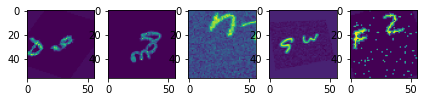

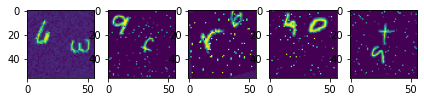

[(3, 'd'), (8, 'm'), (7, 'n'), (9, 'w'), (2, 'f'), (6, 'w'), (9, 'f'), (6, 'r'), (4, 'd'), (9, 't')]


In [27]:
def show_sample(n):
  perm = torch.randperm(len(training_dataset))
  idx = perm[:n]
  data, labels = training_dataset[idx]
  img_grid(n//5,5 , data[:,0])
  print(convert_labels_to_readables(labels))
show_sample(10)

## Training Model

### Multi-Output Model

Initalize the Multilabel Model

In [ ]:
class MultiNet(nn.Module):
    def __init__(self):
        super(MultiNet, self).__init__()
         # 4 convolution layer
        self.conv1 = nn.Conv2d(1, 64, 3, padding='same')
        self.conv2 = nn.Conv2d(64, 64, 3, padding='same')
        self.conv3 = nn.Conv2d(64, 128, 3, padding='same')
        self.conv4 = nn.Conv2d(128, 256, 3, padding='same')
        
        self.pool2 = nn.MaxPool2d(2, 2)

        # 3 Dense Layer
        self.fc11 = nn.Linear(256*3*3, 1000)
        self.fc12 = nn.Linear(256*3*3, 1000)
        self.fc21 = nn.Linear(1000, 100)
        self.fc22 = nn.Linear(1000, 1000)
        self.fc31 = nn.Linear(100, 10)
        self.fc32 = nn.Linear(1000, 26)

    def forward(self, x):
        # Convolution Layers
        x = F.relu(self.conv1(x))
        x = self.pool2(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        # print(x.size())
        # Dense Layers
        x = x.view(-1,self.num_flat_features(x)) # Flatten
        l1 = F.relu(self.fc21(F.relu(self.fc11(x))))
        l2 = F.relu(self.fc22(F.relu(self.fc12(x))))
        l1 = self.fc31(l1)
        l2 = self.fc32(l2)
        return l1,l2
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Custom Res Net with Multi Output




In [32]:
class Block(nn.Module):
  def __init__(self, inplane, outplane, stride = 1):
    super(Block, self).__init__()
    self.inplane = inplane
    self.outplane = outplane
    self.relu = nn.ReLU(inplace=True)
    
    self.conv1 = nn.Conv2d(inplane, outplane, 3, padding=1, bias=False, stride=stride)
    self.bn1 = nn.BatchNorm2d(outplane)
    self.conv2 = nn.Conv2d(outplane, outplane, 3, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(outplane)
    
    self.convi, self.bni = nn.Identity(), nn.Identity()
    if inplane != outplane or stride != 1: 
      self.convi = nn.Conv2d(inplane, outplane, 1, bias=False, stride=stride)
      self.bni = nn.BatchNorm2d(outplane)
  
  def forward(self, x):
        identity = self.bni(self.convi(x))

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 80, 3, padding=1, bias=False)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(80)
        
        # 4 Residual Layers
        self.layer1 = Block(64, 64)
        self.layer2 = Block(64, 128)
        self.layer3 = Block(128, 256, 2)
        self.layer4 = Block(256, 512, 2)

        # self.layer4 = self._make_layer(models.resnet.BasicBlock, 512, 1, stride=2)
        self.avgpool = nn.AvgPool2d(3, stride=1)
        self.fc1 = nn.Linear(2048, 10)
        self.fc2 = nn.Linear(2048, 26)        

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        l1 = self.fc1(x)
        l2 = self.fc2(x)
        return l1,l2


### Training and Validation

Initialize network validation and training function

In [29]:
def validate_model(model):
  digit_acc, letter_acc = 0, 0
  print("Starting Validation Iteration")
  for i, validation_data in enumerate(tqdm(validation_loader)):
    inputs, labels = validation_data
    o1, o2 = model(inputs)
    l1, l2 = labels[:,0], labels[:,1]
    digit_acc += torch.mean((torch.argmax(o1, dim=1) == l1).float()).float()
    letter_acc += torch.mean((torch.argmax(o2, dim=1) == l2).float())
  digit_acc = digit_acc/len(validation_loader)
  letter_acc = letter_acc / len(validation_loader)
  print(f'\n Digit Accuracy: {digit_acc.item()}, Letter Accuracy: {letter_acc.item()}')
  return (digit_acc.item(), letter_acc.item())

In [30]:
def train_network(net, optimizer, criterion, max_epoch = 10, last_index = len(training_loader), do_validation = True):
  running_loss = 0.0
  digits_accs, letter_accs = [], []
  for epoch in range(max_epoch):  # loop over the dataset multiple times
      cnt = 0
      print("Starting Training Iteration")
      for i, data in enumerate(tqdm(training_loader)):
          if epoch == max_epoch - 1 and i > last_index:
            break
          inputs, labels = data
          optimizer.zero_grad()
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          cnt+=1
          if i % 100 == 99:
            print('[%d] loss: %.3f' % (i // 100, running_loss / cnt))
            running_loss, cnt = 0.0, 0
      if do_validation:
        digit_acc, letter_acc = validate_model(net)
        digits_accs.append(digit_acc)
        letter_accs.append(letter_acc)
        return (digits_accs, letter_accs)

In [33]:
def train_model(net, optimizer, do_validation = True, epoch = 1, last_index = len(training_loader)):
  multi_net_criterion = nn.CrossEntropyLoss()
  def ml_criterion(output, labels):
    o1, o2 = output
    l1, l2 = labels[:,0], labels[:,1]
    loss1 = multi_net_criterion(o1,l1)
    loss2 = multi_net_criterion(o2,l2)
    return loss1 + loss2
  if do_validation:
    res = train_network(net, optimizer, criterion=ml_criterion, max_epoch=epoch, last_index=last_index)
    digit_accuracies, letter_accuracies = res
  else: 
    res = train_network(net, optimizer, criterion=ml_criterion,  max_epoch=epoch, last_index=last_index, do_validation=do_validation)
  return net

lr, momentum, weight_decay = 0.01, 0.9, 1e-5
net = CustomResNet()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
net = train_model(net, optimizer, epoch = 1)

Starting Training Iteration


  2%|▏         | 100/6300 [02:16<2:20:49,  1.36s/it]

[0] loss: 5.942


  3%|▎         | 200/6300 [04:32<2:18:21,  1.36s/it]

[1] loss: 5.442


  5%|▍         | 300/6300 [06:47<2:14:57,  1.35s/it]

[2] loss: 5.245


  6%|▋         | 400/6300 [09:02<2:12:16,  1.35s/it]

[3] loss: 4.959


  8%|▊         | 500/6300 [11:19<2:10:58,  1.35s/it]

[4] loss: 4.624


 10%|▉         | 600/6300 [13:33<2:07:45,  1.34s/it]

[5] loss: 4.350


 11%|█         | 700/6300 [15:47<2:06:08,  1.35s/it]

[6] loss: 3.946


 13%|█▎        | 800/6300 [18:02<2:02:50,  1.34s/it]

[7] loss: 3.601


 14%|█▍        | 900/6300 [20:16<2:01:20,  1.35s/it]

[8] loss: 3.295


 16%|█▌        | 1000/6300 [22:31<1:58:28,  1.34s/it]

[9] loss: 3.081


 17%|█▋        | 1100/6300 [24:46<1:57:17,  1.35s/it]

[10] loss: 2.884


 19%|█▉        | 1200/6300 [27:00<1:53:57,  1.34s/it]

[11] loss: 2.666


 21%|██        | 1300/6300 [29:14<1:52:22,  1.35s/it]

[12] loss: 2.488


 22%|██▏       | 1400/6300 [31:29<1:49:47,  1.34s/it]

[13] loss: 2.396


 24%|██▍       | 1500/6300 [33:43<1:46:53,  1.34s/it]

[14] loss: 2.200


 25%|██▌       | 1600/6300 [35:59<1:46:11,  1.36s/it]

[15] loss: 2.083


 27%|██▋       | 1700/6300 [38:14<1:44:01,  1.36s/it]

[16] loss: 2.010


 29%|██▊       | 1800/6300 [40:28<1:40:21,  1.34s/it]

[17] loss: 1.874


 30%|███       | 1900/6300 [42:43<1:38:31,  1.34s/it]

[18] loss: 1.841


 32%|███▏      | 2000/6300 [44:57<1:36:15,  1.34s/it]

[19] loss: 1.739


 33%|███▎      | 2100/6300 [47:12<1:34:59,  1.36s/it]

[20] loss: 1.603


 35%|███▍      | 2200/6300 [49:27<1:31:24,  1.34s/it]

[21] loss: 1.610


 37%|███▋      | 2300/6300 [51:42<1:29:27,  1.34s/it]

[22] loss: 1.554


 38%|███▊      | 2400/6300 [53:57<1:27:21,  1.34s/it]

[23] loss: 1.373


 40%|███▉      | 2500/6300 [56:11<1:25:44,  1.35s/it]

[24] loss: 1.419


 41%|████▏     | 2600/6300 [58:26<1:22:40,  1.34s/it]

[25] loss: 1.363


 43%|████▎     | 2700/6300 [1:00:40<1:20:48,  1.35s/it]

[26] loss: 1.347


 44%|████▍     | 2800/6300 [1:02:55<1:18:43,  1.35s/it]

[27] loss: 1.251


 46%|████▌     | 2900/6300 [1:05:10<1:16:31,  1.35s/it]

[28] loss: 1.248


 48%|████▊     | 3000/6300 [1:07:25<1:14:10,  1.35s/it]

[29] loss: 1.211


 49%|████▉     | 3100/6300 [1:09:40<1:11:34,  1.34s/it]

[30] loss: 1.231


 51%|█████     | 3200/6300 [1:11:55<1:10:00,  1.35s/it]

[31] loss: 1.162


 52%|█████▏    | 3300/6300 [1:14:10<1:07:35,  1.35s/it]

[32] loss: 1.159


 54%|█████▍    | 3400/6300 [1:16:24<1:05:22,  1.35s/it]

[33] loss: 1.026


 56%|█████▌    | 3500/6300 [1:18:39<1:02:41,  1.34s/it]

[34] loss: 1.099


 57%|█████▋    | 3600/6300 [1:20:54<1:00:35,  1.35s/it]

[35] loss: 1.043


 59%|█████▊    | 3700/6300 [1:23:09<59:14,  1.37s/it]

[36] loss: 0.973


 60%|██████    | 3800/6300 [1:25:24<55:55,  1.34s/it]

[37] loss: 0.981


 62%|██████▏   | 3900/6300 [1:27:39<53:47,  1.34s/it]

[38] loss: 0.960


 63%|██████▎   | 4000/6300 [1:29:54<51:19,  1.34s/it]

[39] loss: 0.983


 65%|██████▌   | 4100/6300 [1:32:08<49:55,  1.36s/it]

[40] loss: 0.906


 67%|██████▋   | 4200/6300 [1:34:23<47:17,  1.35s/it]

[41] loss: 0.980


 68%|██████▊   | 4300/6300 [1:36:38<44:44,  1.34s/it]

[42] loss: 0.939


 70%|██████▉   | 4400/6300 [1:38:52<42:39,  1.35s/it]

[43] loss: 0.892


 71%|███████▏  | 4500/6300 [1:41:08<40:41,  1.36s/it]

[44] loss: 0.897


 73%|███████▎  | 4600/6300 [1:43:23<38:12,  1.35s/it]

[45] loss: 0.856


 75%|███████▍  | 4700/6300 [1:45:39<35:47,  1.34s/it]

[46] loss: 0.862


 76%|███████▌  | 4800/6300 [1:47:54<33:56,  1.36s/it]

[47] loss: 0.850


 78%|███████▊  | 4900/6300 [1:50:09<31:47,  1.36s/it]

[48] loss: 0.816


 79%|███████▉  | 5000/6300 [1:52:24<29:09,  1.35s/it]

[49] loss: 0.819


 81%|████████  | 5100/6300 [1:54:39<26:56,  1.35s/it]

[50] loss: 0.761


 83%|████████▎ | 5200/6300 [1:56:54<24:43,  1.35s/it]

[51] loss: 0.805


 84%|████████▍ | 5300/6300 [1:59:09<22:24,  1.34s/it]

[52] loss: 0.761


 86%|████████▌ | 5400/6300 [2:01:23<20:07,  1.34s/it]

[53] loss: 0.817


 87%|████████▋ | 5500/6300 [2:03:38<17:52,  1.34s/it]

[54] loss: 0.771


 89%|████████▉ | 5600/6300 [2:05:54<15:52,  1.36s/it]

[55] loss: 0.685


 90%|█████████ | 5700/6300 [2:08:10<13:37,  1.36s/it]

[56] loss: 0.714


 92%|█████████▏| 5800/6300 [2:10:25<11:17,  1.35s/it]

[57] loss: 0.688


 94%|█████████▎| 5900/6300 [2:12:40<09:00,  1.35s/it]

[58] loss: 0.750


 95%|█████████▌| 6000/6300 [2:14:55<06:44,  1.35s/it]

[59] loss: 0.720


 97%|█████████▋| 6100/6300 [2:17:10<04:28,  1.34s/it]

[60] loss: 0.650


 98%|█████████▊| 6200/6300 [2:19:24<02:14,  1.34s/it]

[61] loss: 0.724


100%|██████████| 6300/6300 [2:21:38<00:00,  1.34s/it]

[62] loss: 0.706


100%|██████████| 6300/6300 [2:21:38<00:00,  1.35s/it]


Starting Validation Iteration


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


 Digit Accuracy: 0.9453337788581848, Letter Accuracy: 0.918000340461731


In [ ]:
lr, momentum, weight_decay = 0.00001, 0.9, 1e-5
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
net = train_model(net, optimizer, epoch = 1, last_index=len(training_loader)//20)

Starting Training Iteration


  2%|▏         | 100/6300 [02:13<2:17:36,  1.33s/it]

[0] loss: 0.625


  3%|▎         | 200/6300 [04:26<2:15:20,  1.33s/it]

[1] loss: 0.573


  5%|▍         | 300/6300 [06:40<2:14:15,  1.34s/it]

[2] loss: 0.594


## Results

Quick Sanity check

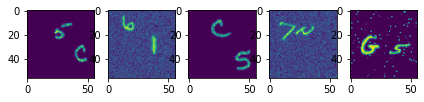

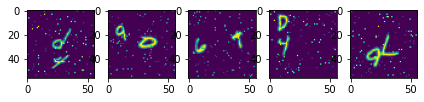

[(5, 'c'), (6, 'i'), (5, 'c'), (7, 'n'), (5, 'g'), (4, 'd'), (9, 'o'), (7, 't'), (0, 'y'), (9, 'l')]


In [ ]:
img_grid(2, 5, testing_dataset[10000:10010,0])
l1, l2 = res_net(testing_dataset[10000:10010])
l1 = np.argmax(l1.detach().numpy(), axis=1)
l2 = np.argmax(l2.detach().numpy(), axis=1)
print(list(zip(l1,map(lambda x: mapping[x], l2))))

In [ ]:
def LabelToString(label, isDigit):
  s = ""
  r = 0
  if (isDigit):
    r = 10
  else:
    r = 26
  for i in range(0, r):
    if (i == label):
      s += '1'
    else:
      s += '0'
  return s

category = []
k = 0
while(k<15000):
  l1,l2 = res_net(testing_dataset[k:k+100])
  l1 = np.argmax(l1.detach().numpy(), axis=1)
  l2 = np.argmax(l2.detach().numpy(), axis=1)
  for i in range(0, len(l1)):
    a = LabelToString(l1[i], True)
    b = LabelToString(l2[i], False)
    category.append(a+b)
    k += 1

In [ ]:
id = []
for i in range(0, 15000):
  id.append(i)
# need to create data dict
data = {
    '# Id' : id,
    'Category' : category
}

df = pd.DataFrame(data=data, columns= ['# Id', 'Category'])
print(df)
df.to_csv('/content/drive/My Drive/data/results.csv', index = False, header=True)

        # Id                              Category
0          0  100000000000000000000000000001000000
1          1  000010000000000000000100000000000000
2          2  000000000100000000010000000000000000
3          3  100000000000000000000100000000000000
4          4  000000100000000000010000000000000000
...      ...                                   ...
14995  14995  000100000000001000000000000000000000
14996  14996  000100000010000000000000000000000000
14997  14997  000000100000000000000000001000000000
14998  14998  010000000000000000100000000000000000
14999  14999  001000000000000000001000000000000000

[15000 rows x 2 columns]


In [ ]:
torch.save(res_net.state_dict(), 'res_net_v2_checkpoint.pth')